In [ ]:
# ALPHA VERSION 11.1 ==========================================================
# Apply market indicators and basic commonality analysis
# to detect bottom and trigger via Telegram & Socket.
# Then Create new database on MariaDB
# =============================================================================
# Library for process Datetime
from datetime import datetime, timedelta
import time
import pytz
# Library for Data Analysis
import pandas as pd
# Library for POST GET & Socket requests
import requests
import urllib.parse
import json
import socket
# Connect to mariaDB to perform CRUD
import mariadb

# Pre-define and CORE Function ================================================
# Database connection parameters
conn_params= {
    # "host" : "103.173.66.235",
    "host" : "localhost",
    "database" : "crypto",
    "user" : "root",
    "password" : "Trien825590"
}
# Define the list of 40 interesting coins
tuple_coin = (
  "UNIVNDC","CETUSVNDC","DOGEVNDC","JASMYVNDC","SOLVNDC",
  "MCAKEVNDC","SXPVNDC","CKBVNDC","EGPT1000VNDC","UXLINKVNDC",
  "MIAVNDC","MOODENGVNDC","EDU3VNDC","MEON1000VNDC","DOGSVNDC",
  "SUIVNDC","FOXYVNDC","BIGTIMEVNDC","TRUVNDC","OPVNDC",
  "LINKVNDC","XRPVNDC","1000CATVNDC","WIFVNDC","NEIROVNDC",
  "XLMVNDC","KSMVNDC","DOTVNDC","ENSVNDC","SANDVNDC",
  "GRASSVNDC","LYNXVNDC","AVAXVNDC","LISTAVNDC","TIAVNDC",
  "PEPE1000VNDC","WLDVNDC", "ADAVNDC", "HBARVNDC", "LDOVNDC"
)

# Define the GMT+7 timezone
timezone = pytz.timezone('Asia/Bangkok')
# Store last trigger timestamp, delay to avoid spam by continuous triggering
last_trigger = [0.0] * len(tuple_coin)
# Set the interval for the status message (in seconds)
interval = 60*60  # 1 hours in seconds
# Check point of important handling - in UNIX timestamp
check_point = time.time()

# Define your quiet hours not to send Telegram
quiet_hours = [
    ((22, 0),(23, 59)),  # 10 PM to midnight
    ((0, 0),(6, 0))      # Midnight to 6 AM
]

# Function to send a message to Telegram
def send_telegram(message_string, max_retry=2):
    # Telegram bot token and chat ID
    TOKEN = "5614737400:AAHbvZrJbomt09EkpPuhadBCJl7NaGu6rlg"
    ID = "5559031253"

    # Check if the time now is quiet hour or not
    current_time = datetime.now(timezone)
    for start, end in quiet_hours:
        quiet_start = current_time.replace(hour=start[0], minute=start[1], second=0, microsecond=0)
        quiet_end = current_time.replace(hour=end[0], minute=end[1], second=59, microsecond=0)
        if quiet_start <= current_time <= quiet_end:
            return False
    # Then continue process send to Telegram
    current_retry = 0
    while (current_retry <= max_retry):
        date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
        if current_retry > 0:
            print(f"{date_time} Telegram: Retry #{current_retry}")
            time.sleep(5)   # Wait a second to stabilize the server
        try:
            # URL encode the message string
            encoded_message = urllib.parse.quote(message_string)
            # Construct the URL
            url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={ID}&text={encoded_message}"
            # Send the request
            response = requests.post(url, timeout=5)
            response.raise_for_status()
            return True
        except requests.exceptions.RequestException as e:            
            print(date_time, f"ERROR send Telegram: \n{e}")
            current_retry += 1
            if current_retry > max_retry:
                print(date_time, "TELEGRAM: Max retries reached.")
                return False
        except requests.exceptions.HTTPError as http_err:
            print(f"Telegram HTTP error occurred: {http_err}")  # Handle the HTTP error
        except Exception as err:
            print(f"Telegram other error occurred: {err}")      # Handle any other errors

# Function get price 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 12h, 1d
def get_data(coin_name, time_unit, time_range, max_retry=5, time_out=10):
    current_retry = 0
    url = "https://api-pro.goonus.io/perpetual/v1/klines"
    # Get the current Unix timestamp value in ms
    current_time = int(time.time()) * 1000
    # Define the parameters for the API request
    params = {
        "symbol": coin_name,
        "interval": time_unit,
        "endTime": current_time,
        # "limit": "600"
    }
    headers = {
        "Content-Type": "application/json",
        "Connection": "keep-alive"
    }
    while current_retry <= max_retry:
        if current_retry > 0:
            print(f"GET Crypto {coin_name}: Retry #{current_retry}")
            time.sleep(5)   # Wait a second to stabilize the server
        try:
            # Try request & get the Response during 5 seconds
            response = requests.get(url, params=params, headers=headers, timeout=time_out)
            # Raise an HTTPError for bad responses (4xx and 5xx)
            response.raise_for_status()

            historical_data = response.json()
            # Map the time_range matching with the total record
            while len(historical_data) < time_range:
                time_range -= 10
            # Check if the data has sufficient 100 records
            if len(historical_data) >= 100:
                # Take the latest "time_range" elements in the list
                historical_data = historical_data[-time_range:]
                # [Time,Open,High,Low,Close,Base qty,Quote qty,Time]
                # Filter to only include 'timestamp' and 'close'
                filtered_data = [[
                    # Convert Unix timestamp -> GMT +7 hours (+25200)
                    datetime.fromtimestamp(int(item[0])/1000, tz=pytz.utc).astimezone(timezone).strftime('%Y-%m-%d %H:%M:%S'),
                    # Close price
                    float(item[4]),
                    # Percentage difference
                    round(100*(float(item[2])-float(item[3]))/float(item[1]),2),
                    float(item[2]), float(item[3])
                ] for item in historical_data]
                # [timestamp, close, %price_diff, Highest, Lowest]
                # print(filtered_data)
                return filtered_data
            else:
                date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
                message = f"Error get {coin_name} - Not enough data ({len(historical_data)})"
                print(date_time, message)
                send_telegram(message)
                return None
        except requests.exceptions.RequestException as e:
            date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
            print(date_time, f"ERROR Request {coin_name} - retry #{current_retry}\n{e}")
            current_retry += 1
            if current_retry > max_retry:
                print(f"{date_time}: Max retries reached. Raising exception.")
                send_telegram(f"ERROR get: {coin_name} - Max retries\n{e}")
                return None
        except requests.exceptions.HTTPError as http_err:
            print(f"Get crypto HTTP error occurred: {http_err}")  # Handle the HTTP error
        except Exception as err:
            print(f"Get crypto other error occurred: {err}")      # Handle any other errors

# Function call API to create in mySQL database ===============================
def create_database(coin_name, test_id, date_trigger, trigger_value, trigger_note, max_retry=2):
    current_retry = 0
    while current_retry <= max_retry:
        date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
        if current_retry > 0:
            print(f"CREATE DB Retry #{current_retry}")
            time.sleep(5)

        # Create connection & implement cursor
        connection = mariadb.connect(**conn_params)
        cursor = connection.cursor()

        try:
            
            # Check if duplicate
            query = "SELECT COUNT(*) FROM `crypto_backtest` WHERE coin_name = ? AND date_trigger = ?"
            data = (coin_name, date_trigger)
            cursor.execute(query,data)
            if cursor.fetchone()[0] > 0:
                print(date_time, "CREATE DB: Duplicate record found")
                # Close Connection & Free resources
                cursor.close()
                connection.close()
                return False
            # Execute the CREATE new record
            query = "INSERT INTO crypto_backtest (coin_name, test_id, date_trigger,trigger_value, trigger_note) VALUES (?,?,?,?,?)"
            data = (coin_name, test_id, date_trigger, trigger_value, trigger_note)
            cursor.execute(query, data)
            connection.commit()
            # Close Connection & Free resources
            cursor.close()
            connection.close()
            # Logging
            print(date_time, "Success create new DB record")
            return True
        except Exception as e:
            print(f"{date_time}: CREATE DB failed\n{e}")
            send_telegram(f"CREATE DB failed #{current_retry}\n{e}")
            current_retry += 1
            if current_retry > max_retry:
                print(f"{date_time}: CREATE DB Max retries reached.")
                send_telegram(f"CREATE DB: Max retries reached.")
                # Close Connection & Free resources
                cursor.close()
                connection.close()
                return False

# Function Send Order via socket ==============================================
def trigger_socket(coin_name, order_price, variance):
    # Make JSON data payload
    data_send = {
        "coin_name": coin_name,
        "order_price": order_price,
        "variance": variance
    }
    date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect(('localhost', 65432))
            s.sendall(json.dumps(data_send).encode('utf-8'))
    except ConnectionRefusedError:
        print(date_time, "Error Socket: Connection refused")

# MARKET INDICATOR Function ===================================================
# Function to calculate the Simple Moving Average (SMA)
def calculate_sma(data, window=5):
    if len(data) < window:
        print("Not enough data to calculate SMA")
        send_telegram("Not enough data to calculate SMA")
        return pd.Series([None] * len(data))
    return data['close'].rolling(window=window).mean()

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window=15):
    if len(data) < window:
        print("Not enough data to calculate RSI")
        send_telegram("Not enough data to calculate RSI")
        return pd.Series([None] * len(data))

    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# MAIN PROGRAM ================================================================
if __name__ == '__main__':
    # Send log to Telegram
    date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
    message = f"{date_time}: Alpha started"
    print(message)
    send_telegram(message)
    
    # Infinite loop to execute
    while True:
        # Example for fetching historical data for one-by-one coin
        # for i in range(1):
        for i in range(len(tuple_coin)):
            # Collect the short-term coin data (1 min)
            datacoin_short = get_data(tuple_coin[i], "1m", 600)
            # time.sleep(1)  # Sleep 1s for stablilize the server request

            if datacoin_short is None:
                continue    # Pass to the next loop

            # Convert to DataFrame for further process
            df = pd.DataFrame(datacoin_short, columns=['timestamp', 'close', 'percent', 'high', 'low'])
            # Format correct data type
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
            df['percent'] = df['percent'].astype(float)
            df['close'] = df['close'].astype(float)
            df['high'] = df['high'].astype(float)
            df['low'] = df['low'].astype(float)
            # Calculate average number of 'percent' last 30 records
            df['variance'] = df['percent'].rolling(window=30).mean()

            # Measure the Statistical Indicators =============================
            df['SMA_5'] = calculate_sma(df, 6)
            # Calculate the percentage difference
            # df['SMA_5_diff'] = df['SMA_5'].diff()
            df['SMA_5_diff'] = df['SMA_5'].diff() / df['SMA_5'].shift(1) * 100
            df['SMA_25'] = calculate_sma(df, 25)
            df['RSI_15'] = calculate_rsi(df)
            df['diff'] = 100 * (df['SMA_5'] - df['SMA_25']) / df['close']
            # Set the timestamp as the index
            # df.set_index('timestamp', inplace=True)
            # display(df)

            # Implement the swing strategy: buy the lowest
            average_before = df['SMA_5_diff'].iloc[-8:-3].mean()
            average_after = df['SMA_5_diff'].tail(3).mean()
            multiple = average_after * average_before

            # ALPHA Condition =================================================
            if  (df.iloc[-1]['diff'] <= -0.3) and\
                (df.iloc[-1]['RSI_15'] < 30) and\
                ((time.time() - last_trigger[i]) >= 900) and\
                (df.iloc[-1]['variance'] > 0.1) and\
                (average_before < 0) and (multiple < 0):

                message = f"""	SMA5: {round(df.iloc[-1]['diff'], 3)} 
	SMA25: {round(df.iloc[-1]['SMA_25'], 3)} 
	Diff: {round(df.iloc[-1]['diff'], 3)} 
	RSI15: {round(df.iloc[-1]['RSI_15'], 1)} 
	Variance: {round(df.iloc[-1]['variance'], 3)} 
	Before: {round(average_before, 3)} 
	After: {round(average_after, 3)}"""

                date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
                print(date_time, tuple_coin[i]+"\n"+ message)
                send_telegram(tuple_coin[i] + "\n" + message)
                last_trigger[i] = time.time()
                # Create new Record in Back Testing database
                create_database(tuple_coin[i], "BT08", date_time, df.iloc[-1]['close'].astype(str), message)
                # Trigger signal via socket to place order
                trigger_socket(tuple_coin[i], df.iloc[-1]['close'],df.iloc[-1]['variance'])

        current_time = time.time()
        if (current_time - check_point) >= interval:
            date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
            check_point = current_time
            # Process Back Testing
            send_telegram("Alpha still working")

        time.sleep(5)

2024-12-15 17:20:28: Alpha started
[['2024-12-15 07:21:00', 400944.0, 0.08, 401136.0, 400800.0], ['2024-12-15 07:22:00', 401592.0, 0.2, 401735.0, 400920.0], ['2024-12-15 07:23:00', 401088.0, 0.15, 401688.0, 401088.0], ['2024-12-15 07:24:00', 401112.0, 0.05, 401280.0, 401064.0], ['2024-12-15 07:25:00', 401016.0, 0.07, 401280.0, 401016.0], ['2024-12-15 07:26:00', 401544.0, 0.2, 401807.0, 401016.0], ['2024-12-15 07:27:00', 401400.0, 0.1, 401592.0, 401184.0], ['2024-12-15 07:28:00', 401184.0, 0.08, 401472.0, 401160.0], ['2024-12-15 07:29:00', 401256.0, 0.06, 401280.0, 401040.0], ['2024-12-15 07:30:00', 401087.0, 0.05, 401256.0, 401040.0], ['2024-12-15 07:31:00', 400272.0, 0.26, 401280.0, 400248.0], ['2024-12-15 07:32:00', 400152.0, 0.09, 400272.0, 399912.0], ['2024-12-15 07:33:00', 398856.0, 0.33, 400175.0, 398856.0], ['2024-12-15 07:34:00', 399216.0, 0.2, 399600.0, 398808.0], ['2024-12-15 07:35:00', 397848.0, 0.34, 399216.0, 397848.0], ['2024-12-15 07:36:00', 397680.0, 0.08, 397944.0, 397

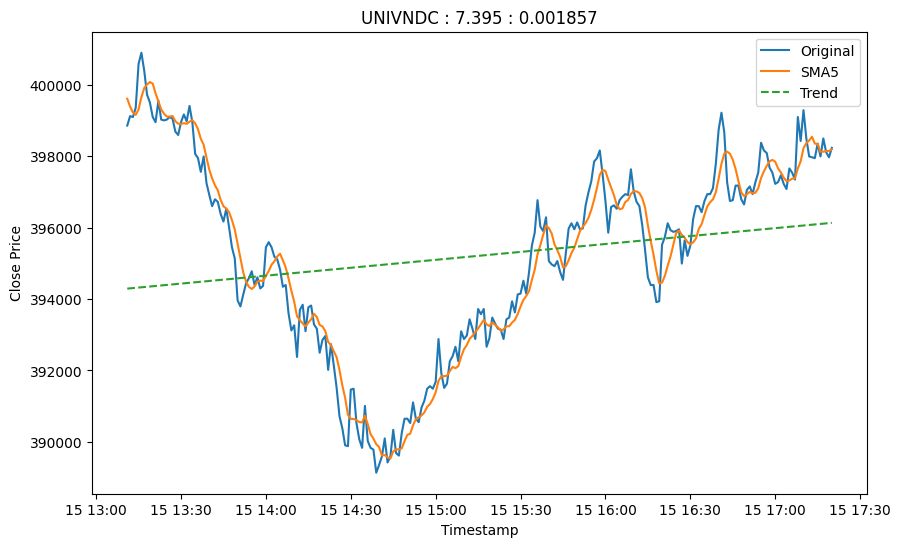

[['2024-12-15 07:21:00', 9239.6, 0.08, 9244.3, 9237.2], ['2024-12-15 07:22:00', 9250.6, 0.17, 9255.1, 9239.6], ['2024-12-15 07:23:00', 9263.5, 0.2, 9266.5, 9248.0], ['2024-12-15 07:24:00', 9259.4, 0.11, 9263.6, 9253.0], ['2024-12-15 07:25:00', 9256.4, 0.08, 9259.5, 9252.5], ['2024-12-15 07:26:00', 9268.1, 0.38, 9289.3, 9254.0], ['2024-12-15 07:27:00', 9260.6, 0.17, 9271.4, 9255.9], ['2024-12-15 07:28:00', 9251.5, 0.16, 9265.9, 9251.5], ['2024-12-15 07:29:00', 9253.0, 0.05, 9255.1, 9250.6], ['2024-12-15 07:30:00', 9252.2, 0.06, 9253.0, 9247.5], ['2024-12-15 07:31:00', 9214.9, 0.45, 9256.3, 9214.9], ['2024-12-15 07:32:00', 9201.4, 0.15, 9215.4, 9201.4], ['2024-12-15 07:33:00', 9187.9, 0.17, 9202.1, 9186.3], ['2024-12-15 07:34:00', 9184.6, 0.14, 9194.4, 9181.5], ['2024-12-15 07:35:00', 9151.2, 0.36, 9184.6, 9151.2], ['2024-12-15 07:36:00', 9151.4, 0.04, 9152.4, 9148.8], ['2024-12-15 07:37:00', 9148.3, 0.09, 9152.4, 9144.0], ['2024-12-15 07:38:00', 9145.6, 0.09, 9149.0, 9140.6], ['2024-12-

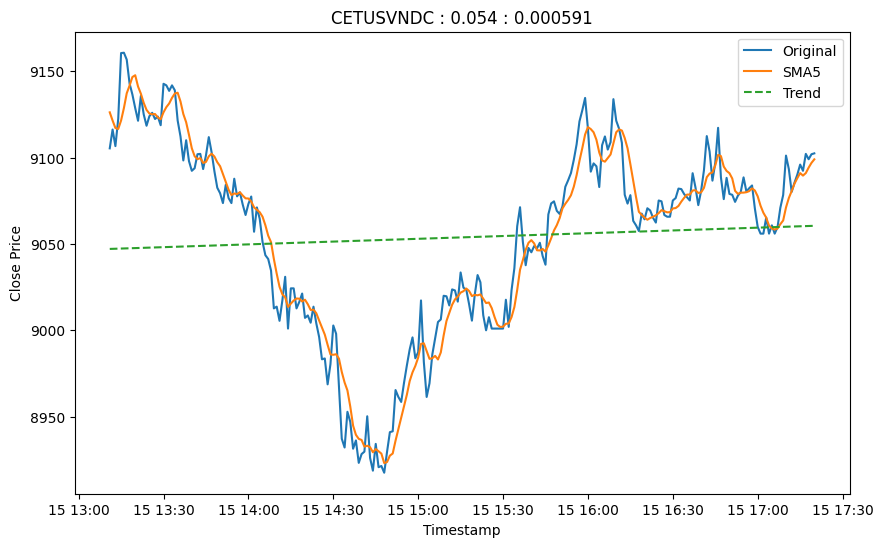

[['2024-12-15 07:21:00', 9524.9, 0.14, 9537.8, 9524.0], ['2024-12-15 07:22:00', 9538.0, 0.19, 9543.2, 9524.9], ['2024-12-15 07:23:00', 9543.3, 0.17, 9546.9, 9530.3], ['2024-12-15 07:24:00', 9551.9, 0.1, 9553.9, 9544.5], ['2024-12-15 07:25:00', 9556.7, 0.07, 9556.9, 9550.2], ['2024-12-15 07:26:00', 9569.8, 0.19, 9572.5, 9554.2], ['2024-12-15 07:27:00', 9563.4, 0.13, 9569.8, 9557.2], ['2024-12-15 07:28:00', 9562.0, 0.07, 9569.1, 9562.0], ['2024-12-15 07:29:00', 9564.2, 0.03, 9566.1, 9562.9], ['2024-12-15 07:30:00', 9560.6, 0.09, 9565.4, 9556.7], ['2024-12-15 07:31:00', 9559.5, 0.22, 9562.9, 9542.0], ['2024-12-15 07:32:00', 9533.7, 0.29, 9559.5, 9532.0], ['2024-12-15 07:33:00', 9510.2, 0.28, 9537.3, 9510.2], ['2024-12-15 07:34:00', 9514.7, 0.2, 9527.7, 9509.0], ['2024-12-15 07:35:00', 9492.3, 0.25, 9514.7, 9490.5], ['2024-12-15 07:36:00', 9496.6, 0.17, 9505.2, 9489.2], ['2024-12-15 07:37:00', 9487.4, 0.16, 9501.7, 9486.9], ['2024-12-15 07:38:00', 9491.5, 0.1, 9496.9, 9487.4], ['2024-12-15

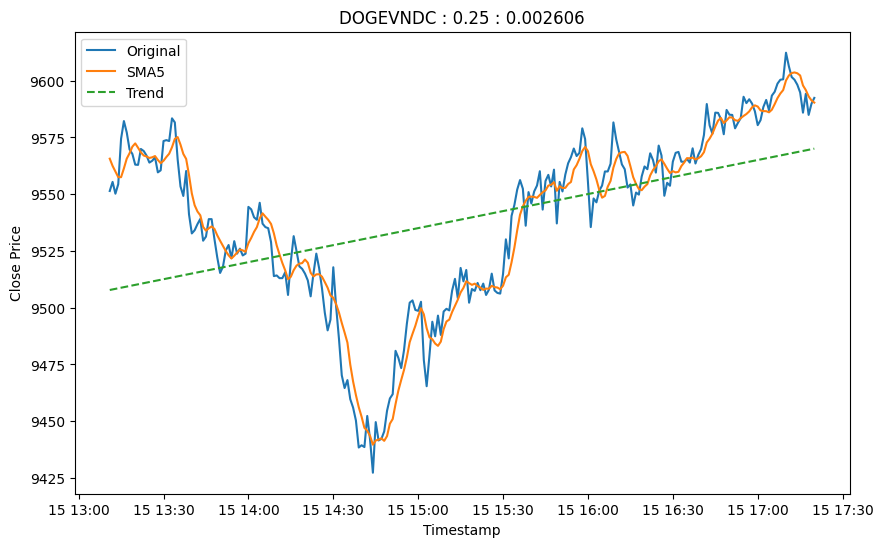

[['2024-12-15 07:21:00', 1041.576, 0.08, 1042.251, 1041.453], ['2024-12-15 07:22:00', 1043.306, 0.21, 1043.691, 1041.507], ['2024-12-15 07:23:00', 1043.666, 0.08, 1043.786, 1042.97], ['2024-12-15 07:24:00', 1043.57, 0.09, 1043.883, 1042.898], ['2024-12-15 07:25:00', 1044.123, 0.11, 1044.123, 1042.994], ['2024-12-15 07:26:00', 1045.159, 0.15, 1045.251, 1043.71], ['2024-12-15 07:27:00', 1043.979, 0.12, 1045.159, 1043.883], ['2024-12-15 07:28:00', 1043.686, 0.09, 1044.556, 1043.595], ['2024-12-15 07:29:00', 1044.843, 0.12, 1044.843, 1043.57], ['2024-12-15 07:30:00', 1043.451, 0.15, 1044.843, 1043.307], ['2024-12-15 07:31:00', 1039.059, 0.47, 1043.979, 1039.059], ['2024-12-15 07:32:00', 1037.643, 0.21, 1039.779, 1037.643], ['2024-12-15 07:33:00', 1036.613, 0.12, 1037.81, 1036.613], ['2024-12-15 07:34:00', 1037.259, 0.29, 1037.547, 1034.553], ['2024-12-15 07:35:00', 1033.747, 0.34, 1037.259, 1033.747], ['2024-12-15 07:36:00', 1033.398, 0.07, 1034.163, 1033.398], ['2024-12-15 07:37:00', 1032

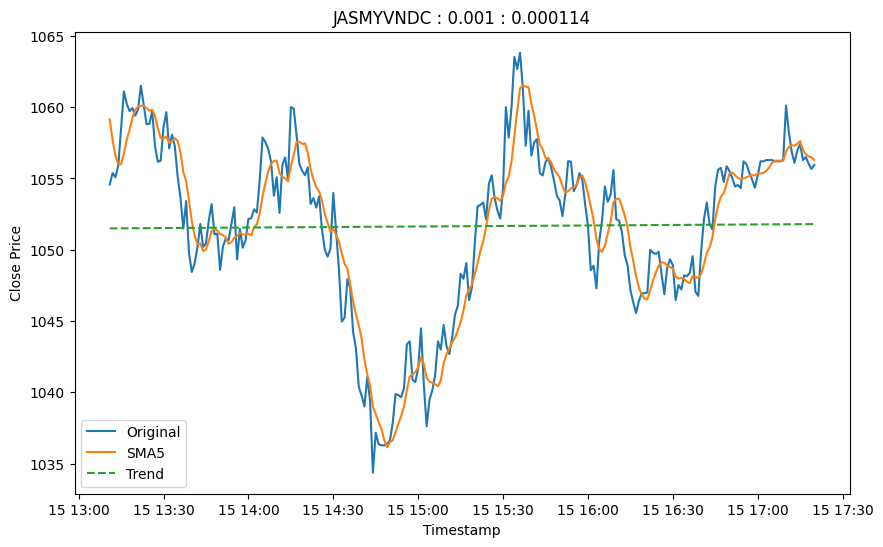

[['2024-12-15 07:21:00', 5276400.0, 0.1, 5281680.0, 5276160.0], ['2024-12-15 07:22:00', 5282880.0, 0.14, 5283600.0, 5276400.0], ['2024-12-15 07:23:00', 5281920.0, 0.06, 5283600.0, 5280240.0], ['2024-12-15 07:24:00', 5283840.0, 0.09, 5285520.0, 5280960.0], ['2024-12-15 07:25:00', 5284320.0, 0.03, 5284560.0, 5283120.0], ['2024-12-15 07:26:00', 5290320.0, 0.18, 5293929.0, 5284320.0], ['2024-12-15 07:27:00', 5286720.0, 0.17, 5295200.0, 5286000.0], ['2024-12-15 07:28:00', 5286720.0, 0.05, 5289600.0, 5286720.0], ['2024-12-15 07:29:00', 5288160.0, 0.04, 5288880.0, 5286720.0], ['2024-12-15 07:30:00', 5284320.0, 0.24, 5288160.0, 5275675.0], ['2024-12-15 07:31:00', 5276400.0, 0.17, 5285280.0, 5276400.0], ['2024-12-15 07:32:00', 5272320.0, 0.11, 5276400.0, 5270400.0], ['2024-12-15 07:33:00', 5265360.0, 0.13, 5272320.0, 5265360.0], ['2024-12-15 07:34:00', 5269200.0, 0.1, 5270400.0, 5264880.0], ['2024-12-15 07:35:00', 5260080.0, 0.17, 5269200.0, 5260080.0], ['2024-12-15 07:36:00', 5258160.0, 0.04, 

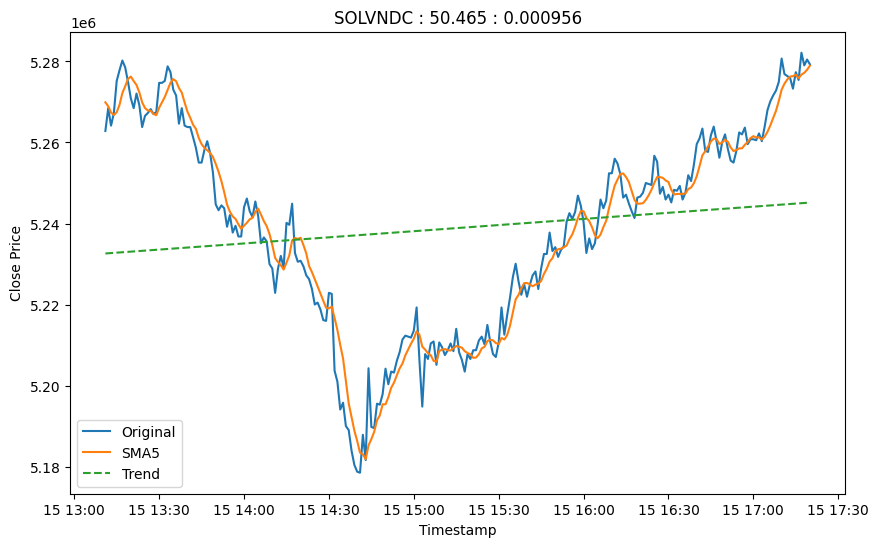

KeyboardInterrupt: 

In [8]:
# ALPHA VERSION 11.2 ==========================================================
# Apply market indicators and basic commonality analysis
# to detect bottom and trigger via Telegram & Socket.
# Then Create new database on MariaDB
# =============================================================================
# Library for process Datetime
from datetime import datetime, timedelta
import time
import pytz
# Library for Data Analysis
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
# Library for POST GET & Socket requests
import requests
import urllib.parse
import json
import socket
# Connect to mariaDB to perform CRUD
import mariadb

# Pre-define and CORE Function ================================================
# Database connection parameters
conn_params= {
    "host" : "103.173.66.235",
    # "host" : "localhost",
    "database" : "crypto",
    "user" : "root",
    "password" : "Trien825590"
}
# Define the list of 40 interesting coins
tuple_coin = (
  "UNIVNDC","CETUSVNDC","DOGEVNDC","JASMYVNDC","SOLVNDC",
  "MCAKEVNDC","SXPVNDC","CKBVNDC","EGPT1000VNDC","UXLINKVNDC",
  "MIAVNDC","MOODENGVNDC","EDU3VNDC","MEON1000VNDC","DOGSVNDC",
  "SUIVNDC","FOXYVNDC","BIGTIMEVNDC","TRUVNDC","OPVNDC",
  "LINKVNDC","XRPVNDC","1000CATVNDC","WIFVNDC","NEIROVNDC",
  "XLMVNDC","KSMVNDC","DOTVNDC","ENSVNDC","SANDVNDC",
  "GRASSVNDC","LYNXVNDC","AVAXVNDC","LISTAVNDC","TIAVNDC",
  "PEPE1000VNDC","WLDVNDC", "ADAVNDC", "HBARVNDC", "LDOVNDC",
)
# tuple_good = ("BTCVNDC", "ETHVNDC")

# Define the GMT+7 timezone
timezone = pytz.timezone('Asia/Bangkok')
# Store last trigger timestamp, delay to avoid spam by continuous triggering
last_trigger = [0.0] * len(tuple_coin)
# Set the interval for the status message (in seconds)
interval = 60*60  # 1 hours in seconds
# Check point of important handling - in UNIX timestamp
check_point = time.time()

# Define your quiet hours not to send Telegram
quiet_hours = [
    ((22, 0),(23, 59)),  # 10 PM to midnight
    ((0, 0),(6, 0))      # Midnight to 6 AM
]

# Function to send a message to Telegram
def send_telegram(message_string, max_retry=2):
    # Telegram bot token and chat ID
    TOKEN = "5614737400:AAHbvZrJbomt09EkpPuhadBCJl7NaGu6rlg"
    ID = "5559031253"

    # Check if the time now is quiet hour or not
    current_time = datetime.now(timezone)
    for start, end in quiet_hours:
        quiet_start = current_time.replace(hour=start[0], minute=start[1], second=0, microsecond=0)
        quiet_end = current_time.replace(hour=end[0], minute=end[1], second=59, microsecond=0)
        if quiet_start <= current_time <= quiet_end:
            return False
    # Then continue process send to Telegram
    current_retry = 0
    while (current_retry <= max_retry):
        date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
        if current_retry > 0:
            print(f"{date_time} Telegram: Retry #{current_retry}")
            time.sleep(5)   # Wait a second to stabilize the server
        try:
            # URL encode the message string
            encoded_message = urllib.parse.quote(message_string)
            # Construct the URL
            url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={ID}&text={encoded_message}"
            # Send the request
            response = requests.post(url, timeout=5)
            response.raise_for_status()
            return True
        except requests.exceptions.RequestException as e:            
            print(date_time, f"ERROR send Telegram: \n{e}")
            current_retry += 1
            if current_retry > max_retry:
                print(date_time, "TELEGRAM: Max retries reached.")
                return False
        except requests.exceptions.HTTPError as http_err:
            print(f"Telegram HTTP error occurred: {http_err}")  # Handle the HTTP error
        except Exception as err:
            print(f"Telegram other error occurred: {err}")      # Handle any other errors

# Function get price 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 12h, 1d
def get_data(coin_name, time_unit, time_range, max_retry=5, time_out=10):
    current_retry = 0
    url = "https://api-pro.goonus.io/market/v2/klines"
    # Get the current Unix timestamp value in ms
    current_time = int(time.time()) * 1000
    # Define the parameters for the API request
    params = {
        "symbol": coin_name,
        "interval": time_unit,
        "endTime": current_time,
        # "limit": "600"
    }
    headers = {
        "Content-Type": "application/json",
        "Connection": "keep-alive"
    }
    while current_retry <= max_retry:
        if current_retry > 0:
            print(f"GET Crypto {coin_name}: Retry #{current_retry}")
            time.sleep(5)   # Wait a second to stabilize the server
        try:
            # Try request & get the Response during 5 seconds
            response = requests.get(url, params=params, headers=headers, timeout=time_out)
            # Raise an HTTPError for bad responses (4xx and 5xx)
            response.raise_for_status()

            historical_data = response.json()
            # Map the time_range matching with the total record
            while len(historical_data) < time_range:
                time_range -= 10
            # Check if the data has sufficient 100 records
            if len(historical_data) >= 100:
                # Take the latest "time_range" elements in the list
                historical_data = historical_data[-time_range:]
                # [Time,Open,High,Low,Close,Base qty,Quote qty,Time]
                # Filter to only include 'timestamp' and 'close'
                filtered_data = [[
                    # Convert Unix timestamp -> GMT +7 hours (+25200)
                    datetime.fromtimestamp(int(item[0])/1000, tz=pytz.utc).astimezone(timezone).strftime('%Y-%m-%d %H:%M:%S'),
                    # Close price
                    float(item[4]),
                    # Percentage difference
                    round(100*(float(item[2])-float(item[3]))/float(item[1]),2),
                    float(item[2]), float(item[3])
                ] for item in historical_data]
                # [timestamp, close, %price_diff, Highest, Lowest]
                # print(filtered_data)
                return filtered_data
            else:
                date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
                message = f"Error get {coin_name} - Not enough data ({len(historical_data)})"
                print(date_time, message)
                send_telegram(message)
                return None
        except requests.exceptions.RequestException as e:
            date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
            print(date_time, f"ERROR Request {coin_name} - retry #{current_retry}\n{e}")
            current_retry += 1
            if current_retry > max_retry:
                print(f"{date_time}: Max retries reached. Raising exception.")
                send_telegram(f"ERROR get: {coin_name} - Max retries\n{e}")
                return None
        except requests.exceptions.HTTPError as http_err:
            print(f"Get crypto HTTP error occurred: {http_err}")  # Handle the HTTP error
        except Exception as err:
            print(f"Get crypto other error occurred: {err}")      # Handle any other errors

# Function call API to create in mySQL database ===============================
def create_database(coin_name, test_id, date_trigger, trigger_value, trigger_note, max_retry=2):
    current_retry = 0
    while current_retry <= max_retry:
        date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
        if current_retry > 0:
            print(f"CREATE DB Retry #{current_retry}")
            time.sleep(5)

        # Create connection & implement cursor
        connection = mariadb.connect(**conn_params)
        cursor = connection.cursor()

        try:
            
            # Check if duplicate
            query = "SELECT COUNT(*) FROM `crypto_backtest` WHERE coin_name = ? AND date_trigger = ?"
            data = (coin_name, date_trigger)
            cursor.execute(query,data)
            if cursor.fetchone()[0] > 0:
                print(date_time, "CREATE DB: Duplicate record found")
                # Close Connection & Free resources
                cursor.close()
                connection.close()
                return False
            # Execute the CREATE new record
            query = "INSERT INTO crypto_backtest (coin_name, test_id, date_trigger,trigger_value, trigger_note) VALUES (?,?,?,?,?)"
            data = (coin_name, test_id, date_trigger, trigger_value, trigger_note)
            cursor.execute(query, data)
            connection.commit()
            # Close Connection & Free resources
            cursor.close()
            connection.close()
            # Logging
            print(date_time, "Success create new DB record")
            return True
        except Exception as e:
            print(f"{date_time}: CREATE DB failed\n{e}")
            send_telegram(f"CREATE DB failed #{current_retry}\n{e}")
            current_retry += 1
            if current_retry > max_retry:
                print(f"{date_time}: CREATE DB Max retries reached.")
                send_telegram(f"CREATE DB: Max retries reached.")
                # Close Connection & Free resources
                cursor.close()
                connection.close()
                return False

# Function Send Order via socket ==============================================
def trigger_socket(coin_name, order_price, variance):
    # Make JSON data payload
    data_send = {
        "coin_name": coin_name,
        "order_price": order_price,
        "variance": variance
    }
    date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect(('localhost', 65432))
            s.sendall(json.dumps(data_send).encode('utf-8'))
    except ConnectionRefusedError:
        print(date_time, "Error Socket: Connection refused")

# MARKET INDICATOR Function ===================================================
# Function to calculate the Simple Moving Average (SMA)
def calculate_sma(data, window=5):
    if len(data) < window:
        print("Not enough data to calculate SMA")
        send_telegram("Not enough data to calculate SMA")
        return pd.Series([None] * len(data))
    return data['close'].rolling(window=window).mean()

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window=15):
    if len(data) < window:
        print("Not enough data to calculate RSI")
        send_telegram("Not enough data to calculate RSI")
        return pd.Series([None] * len(data))

    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to pre-process data -> return in pandas
def  process_data(data):
    # Convert to DataFrame for further process
    df = pd.DataFrame(data, columns=['timestamp', 'close', 'percent', 'high', 'low'])
    # Format correct data type
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df['percent'] = df['percent'].astype(float)
    df['close'] = df['close'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    # Calculate average number of 'percent' last 30 records
    df['variance'] = df['percent'].rolling(window=30).mean()

    # Measure the Statistical Indicators =============================
    df['SMA_5'] = calculate_sma(df, 6)
    # Calculate the percentage difference
    # df['SMA_5_diff'] = df['SMA_5'].diff()
    df['SMA_5_diff'] = df['SMA_5'].diff() / df['SMA_5'].shift(1) * 100
    df['SMA_25'] = calculate_sma(df, 25)
    df['RSI_15'] = calculate_rsi(df)
    df['diff'] = 100 * (df['SMA_5'] - df['SMA_25']) / df['close']
    # Set the timestamp as the index
    # df.set_index('timestamp', inplace=True)
    return df

# MAIN PROGRAM ================================================================
if __name__ == '__main__':
    # Send log to Telegram
    date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
    message = f"{date_time}: Alpha started"
    print(message)
    send_telegram(message)
    
    # Infinite loop to execute
    while True:
        # Example for fetching historical data for one-by-one coin
        # for i in range(1):
        for i in range(len(tuple_coin)):
            # Collect the short-term coin data (1 min)
            datacoin_short = get_data(tuple_coin[i], "1m", 600)
            print(datacoin_short)
            # datacoin_medium = get_data(tuple_coin[i], "5m", 30)
            # time.sleep(1)  # Sleep 1s for stablilize the server request

            if (datacoin_short is None):
                continue    # Pass to the next loop
            
            df_short = process_data(datacoin_short)
            # df_medium = process_data(datacoin_medium)
            
            # Implement the swing strategy: buy the lowest in local up trend
            average_before = df_short['SMA_5_diff'].iloc[-8:-3].mean()
            average_after = df_short['SMA_5_diff'].tail(3).mean()
            multiple = average_after * average_before

            # Process Linear Regression
            # Create x,y pair - Limit to the latest 200 records
            df_short_regress = df_short.tail(250)
            X = np.arange(len(df_short_regress)).reshape(-1, 1)
            y = df_short_regress['close'].values
            # Fit the Linear Regression Model
            model = LinearRegression().fit(X, y)
            trend = model.predict(X)
            # Get the Coefficient of the slope
            slope = model.coef_[0]
            slope_rel = round(100*model.coef_[0]/df_short_regress.iloc[-1]['close'], 6)
            # Draw Graph - Testing
            plt.figure(figsize=(10,6))
            plt.plot(df_short_regress['timestamp'], df_short_regress['close'], label='Original')
            plt.plot(df_short_regress['timestamp'], df_short_regress['SMA_5'], label='SMA5')
            plt.plot(df_short_regress['timestamp'], trend, label='Trend', linestyle='--')
            plt.xlabel('Timestamp')
            plt.ylabel('Close Price')
            plt.title(f'{tuple_coin[i]} : {round(slope,3)} : {slope_rel}')
            plt.legend()
            plt.show()
            plt.clf()
            plt.close('all')

            # ALPHA Condition =================================================
            if  (df_short.iloc[-1]['diff'] <= -0.3) and\
                (df_short.iloc[-1]['RSI_15'] < 30) and\
                ((time.time() - last_trigger[i]) >= 900) and\
                (df_short.iloc[-1]['variance'] > 0.1) and\
                (average_before < 0) and (multiple < 0):

                message = f"""	SMA5: {round(df_short.iloc[-1]['diff'], 3)} 
	SMA25: {round(df_short.iloc[-1]['SMA_25'], 3)} 
	Diff: {round(df_short.iloc[-1]['diff'], 3)} 
	RSI15: {round(df_short.iloc[-1]['RSI_15'], 1)} 
	Variance: {round(df_short.iloc[-1]['variance'], 3)} 
	Before: {round(average_before, 3)} 
	After: {round(average_after, 3)}"""

                date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
                print(date_time, tuple_coin[i]+"\n"+ message)
                send_telegram(tuple_coin[i] + "\n" + message)
                last_trigger[i] = time.time()
                # Create new Record in Back Testing database
                # create_database(tuple_coin[i], "BT09", date_time, df_short.iloc[-1]['close'].astype(str), message)
                # Trigger signal via socket to place order
                # trigger_socket(tuple_coin[i], df_short.iloc[-1]['close'],df_short.iloc[-1]['variance'])

        current_time = time.time()
        if (current_time - check_point) >= interval:
            date_time = datetime.now(timezone).strftime('%Y-%m-%d %H:%M:%S')
            check_point = current_time
            # Process Back Testing
            send_telegram("Alpha still working")

        print("End loop")
        time.sleep(5)